In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 

df = pd.read_parquet('data/df_log.parquet.gzip')
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89054 entries, 0 to 89053
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   ip          89054 non-null  string                   
 1   time        89054 non-null  datetime64[ns, UTC-03:00]
 2   request     89054 non-null  string                   
 3   status      89054 non-null  Int64                    
 4   size        89054 non-null  Int64                    
 5   Referer     16769 non-null  string                   
 6   User_agent  88973 non-null  string                   
 7   spambot     89054 non-null  boolean                  
dtypes: Int64(2), boolean(1), datetime64[ns, UTC-03:00](1), string(4)
memory usage: 5.1 MB


In [2]:
df.head(5)

,ip,time,request,status,size,Referer,User_agent,spambot
0,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,<NA>,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True
1,173.252.107.9,2022-03-31 00:00:13-03:00,GET /handle/10915/45833 HTTP/1.1,200,9539,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
2,173.252.107.3,2022-03-31 00:00:13-03:00,GET /handle/10915/31292 HTTP/1.1,200,9512,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
3,173.252.107.22,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True
4,173.252.107.9,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,<NA>,facebookexternalhit/1.1 (+http://www.facebook....,True


In [3]:
df = df[['ip', 'request', 'size', 'spambot']]
df['request'] = df['request'].apply(lambda x: len(x))
df.rename(columns={'request': 'request_lenght'}, inplace=True)
df['spambot_True'] = pd.get_dummies(df, columns = ['spambot'], drop_first=True)['spambot_True']
df.drop('spambot', axis=1, inplace=True)
df.rename(columns={'spambot_True':'spambot'}, inplace=True)
df

,ip,request_lenght,size,spambot
0,3.224.220.101,112,7165,1
1,173.252.107.9,32,9539,1
2,173.252.107.3,32,9512,1
3,173.252.107.22,32,10170,1
4,173.252.107.9,32,10170,1
...,...,...,...,...
89049,5.161.86.47,144,445,0
89050,163.10.48.138,32,8206,0
89051,5.161.86.47,198,167837,0
89052,5.161.87.70,110,411,0


In [4]:
df_groupby_ip = df.groupby(['ip'], as_index=False).size().rename(columns={'size':'count'}) # agrupo por ip y agrego un columna count con la cantidad de requests hechas 
df_groupby_ip['size'] = df.groupby(['ip'], as_index=False)['size'].sum()['size'] # agrego a df_groupby_ip una columna con la cantidad de bytes descargados en un día
df_groupby_ip['request_lenght'] = df['request_lenght']
df_groupby_ip['spambot'] = df.groupby(['ip'], as_index=False)['spambot'].sum()['spambot']
df_groupby_ip

,ip,count,size,request_lenght,spambot
0,1.38.188.99,1,712495,112,0.0
1,1.47.151.27,2,1630020,32,0.0
2,1.85.11.244,1,497562,32,0.0
3,100.24.12.213,2,13623,32,0.0
4,101.108.5.245,1,7725352,32,0.0
...,...,...,...,...,...
8823,98.126.219.75,2,1184056,98,0.0
8824,98.167.168.137,2,224700,88,0.0
8825,98.176.225.232,2,14582,32,0.0
8826,99.150.195.19,6,53034,33,0.0


In [5]:
df_groupby_ip['spambot'] = np.where(df_groupby_ip["spambot"] > 0, 1, 0)
df_groupby_ip

,ip,count,size,request_lenght,spambot
0,1.38.188.99,1,712495,112,0
1,1.47.151.27,2,1630020,32,0
2,1.85.11.244,1,497562,32,0
3,100.24.12.213,2,13623,32,0
4,101.108.5.245,1,7725352,32,0
...,...,...,...,...,...
8823,98.126.219.75,2,1184056,98,0
8824,98.167.168.137,2,224700,88,0
8825,98.176.225.232,2,14582,32,0
8826,99.150.195.19,6,53034,33,0


In [6]:
df_groupby_ip.dtypes

ip                string
count              int64
size               Int64
request_lenght     int64
spambot            int64
dtype: object

### Graficando los datos en escala original


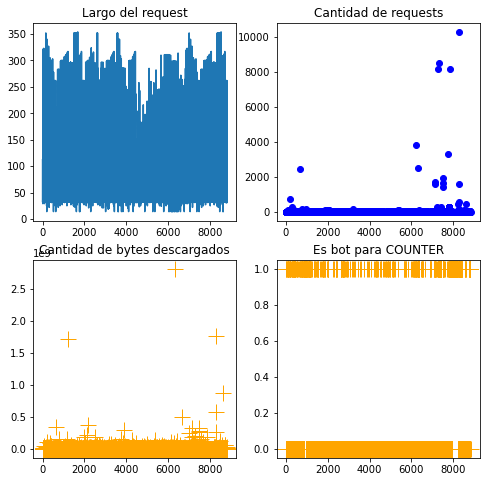

In [7]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.set_title("Largo del request")
ax1.plot(df_groupby_ip['request_lenght'])
ax2.set_title("Cantidad de requests")
ax2.plot(df_groupby_ip["count"], linewidth=0, marker="o", color="blue", markersize=6)
ax3.set_title("Cantidad de bytes descargados")
ax3.plot(df_groupby_ip["size"], linewidth=0, marker="+", color="orange", markersize=16)
ax4.set_title("Es bot para COUNTER")
ax4.plot(df_groupby_ip["spambot"], linewidth=0, marker="+", color="orange", markersize=16)
plt.show()

### Distribución de los datos originales

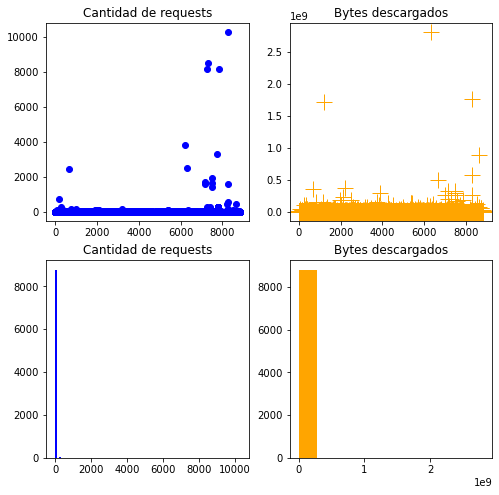

In [8]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.set_title("Cantidad de requests")
ax1.plot(df_groupby_ip["count"], linewidth=0, marker="o", color="blue", markersize=6)
ax2.set_title("Bytes descargados")
ax2.plot(df_groupby_ip["size"], linewidth=0, marker="+", color="orange", markersize=16)
ax3.set_title("Cantidad de requests")
ax3.hist(df_groupby_ip["count"], bins=100, color="blue")
ax4.set_title("Bytes descargados")
ax4.hist(df_groupby_ip["size"], color="orange")
plt.show()

In [9]:
df_robust_scaler = preprocessing.RobustScaler().fit_transform(df_groupby_ip[["count", "size", "spambot", "request_lenght"]])
df_robust_scaler = pd.DataFrame(df_robust_scaler, columns=["count", "size", "spambot", "request_lenght"])

In [10]:
df_co = df_groupby_ip.iloc[:,1:] #probar
#df_co = df_robust_scaler
df_co

,count,size,request_lenght,spambot
0,1,712495,112,0
1,2,1630020,32,0
2,1,497562,32,0
3,2,13623,32,0
4,1,7725352,32,0
...,...,...,...,...
8823,2,1184056,98,0
8824,2,224700,88,0
8825,2,14582,32,0
8826,6,53034,33,0


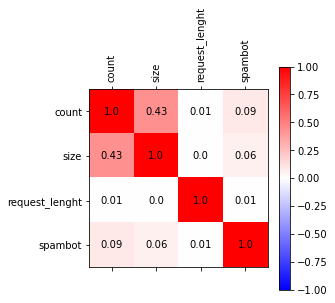

In [11]:
matriz = df_co.corr() # -1 (existe una relación fuerte)  0   1 (existe relación fuerte)
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)
plt.xticks(range(4), df_co.columns, rotation=90)
plt.yticks(range(4), df_co.columns)

for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2),
                 ha="center", va="center")


plt.colorbar()
plt.show()

In [12]:
df_groupby_ip

,ip,count,size,request_lenght,spambot
0,1.38.188.99,1,712495,112,0
1,1.47.151.27,2,1630020,32,0
2,1.85.11.244,1,497562,32,0
3,100.24.12.213,2,13623,32,0
4,101.108.5.245,1,7725352,32,0
...,...,...,...,...,...
8823,98.126.219.75,2,1184056,98,0
8824,98.167.168.137,2,224700,88,0
8825,98.176.225.232,2,14582,32,0
8826,99.150.195.19,6,53034,33,0


In [13]:
df_robust_scaler

,count,size,spambot,request_lenght
0,-0.5,0.189874,0.0,0.134615
1,0.0,0.646839,0.0,-0.634615
2,-0.5,0.082829,0.0,-0.634615
3,0.0,-0.158192,0.0,-0.634615
4,-0.5,3.682559,0.0,-0.634615
...,...,...,...,...
8823,0.0,0.424730,0.0,0.000000
8824,0.0,-0.053067,0.0,-0.096154
8825,0.0,-0.157715,0.0,-0.634615
8826,2.0,-0.138564,0.0,-0.625000


In [14]:
df_groupby_ip.to_parquet('data/df_groupby_ip.parquet.gzip', compression='gzip', index=False)

### KMedias

In [15]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

In [16]:
db_indexes = {}
for n in range(2,10):
    kmeans = KMeans(n).fit(df_robust_scaler.values)
    db_index = davies_bouldin_score(df_robust_scaler.values, kmeans.labels_)
    db_indexes.update({n: db_index})

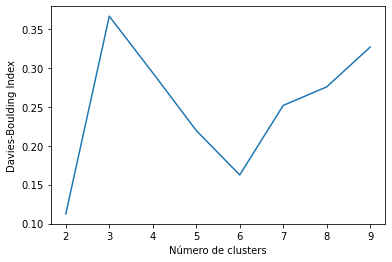

In [17]:
plt.plot(list(db_indexes.keys()), list(db_indexes.values()))
plt.xlabel("Número de clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

In [18]:
n_clusters = 2
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df_groupby_ip["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_
df_robust_scaler

,count,size,spambot,request_lenght,cluster
0,-0.5,0.189874,0.0,0.134615,0
1,0.0,0.646839,0.0,-0.634615,0
2,-0.5,0.082829,0.0,-0.634615,0
3,0.0,-0.158192,0.0,-0.634615,0
4,-0.5,3.682559,0.0,-0.634615,0
...,...,...,...,...,...
8823,0.0,0.424730,0.0,0.000000,0
8824,0.0,-0.053067,0.0,-0.096154,0
8825,0.0,-0.157715,0.0,-0.634615,0
8826,2.0,-0.138564,0.0,-0.625000,0


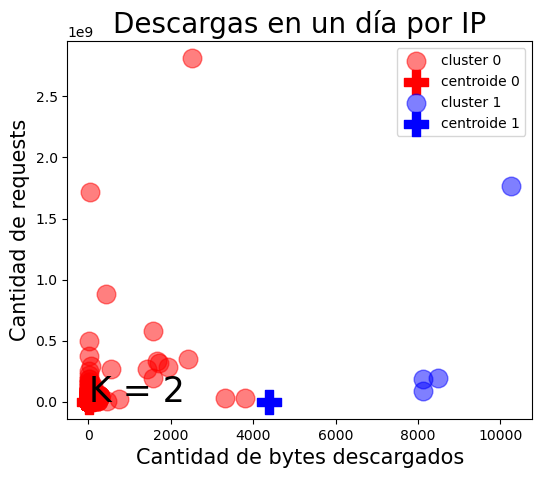

In [19]:
plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_groupby_ip[df_groupby_ip["cluster"] == cluster]["count"],
                df_groupby_ip[df_groupby_ip["cluster"] == cluster]["size"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.show()

A continuación se utilizará la técnica de [Arbol de clasificación](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) para explicar que criterios se usaron para el clustering

In [20]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot", "request_lenght"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)


1.0
|--- cantidad <= 5311.50
|   |--- class: 0
|--- cantidad >  5311.50
|   |--- class: 1



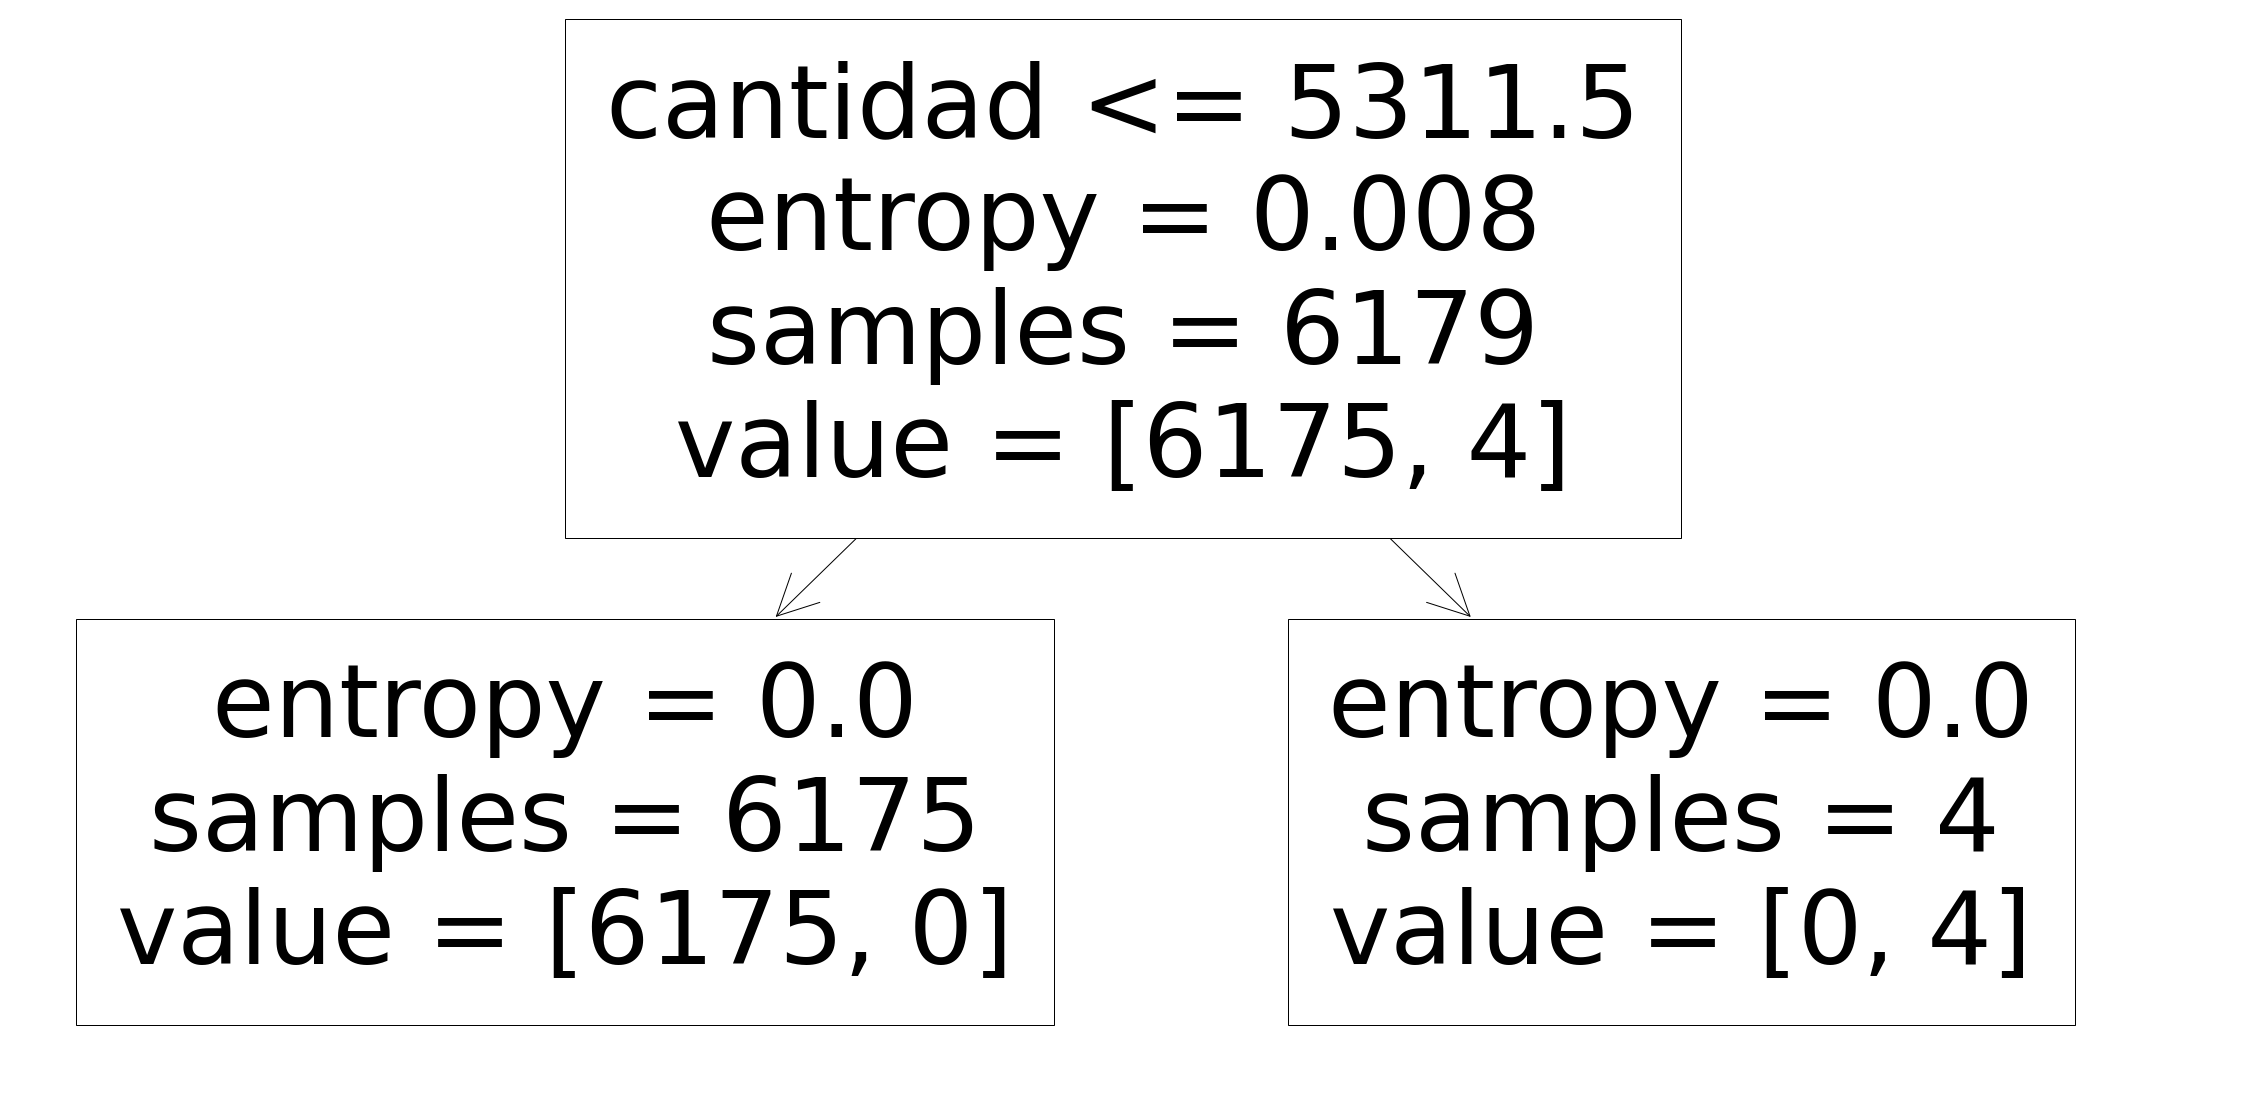

In [21]:
from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["cantidad", "tamaño", "spambot", 'request_lenght']))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["cantidad", "tamaño", "spambot", "request_lenght"])
plt.show()



### KMedias con 6

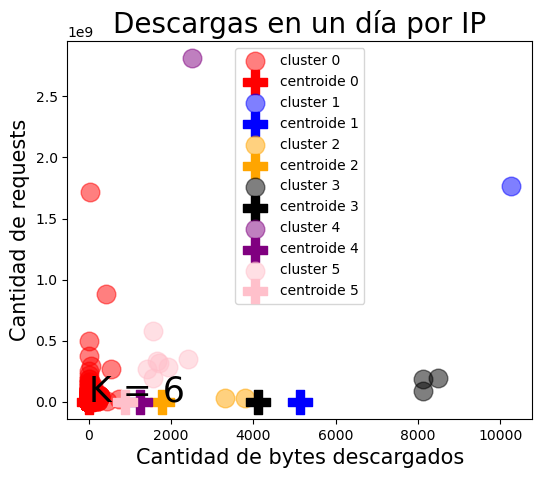

In [22]:
n_clusters = 6
kmeans = KMeans(n_clusters).fit(df_robust_scaler.values)
df_groupby_ip["cluster"] = kmeans.labels_
df_robust_scaler["cluster"] = kmeans.labels_

plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_groupby_ip[df_groupby_ip["cluster"] == cluster]["count"],
                df_groupby_ip[df_groupby_ip["cluster"] == cluster]["size"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.show()

Árbol para explicar kmedias con 6 clusters

1.0
|--- cantidad <= 993.00
|   |--- class: 0
|--- cantidad >  993.00
|   |--- cantidad <= 2462.50
|   |   |--- class: 5
|   |--- cantidad >  2462.50
|   |   |--- cantidad <= 5960.00
|   |   |   |--- cantidad <= 2903.50
|   |   |   |   |--- class: 4
|   |   |   |--- cantidad >  2903.50
|   |   |   |   |--- class: 2
|   |   |--- cantidad >  5960.00
|   |   |   |--- request_lenght <= 188.00
|   |   |   |   |--- class: 3
|   |   |   |--- request_lenght >  188.00
|   |   |   |   |--- class: 1



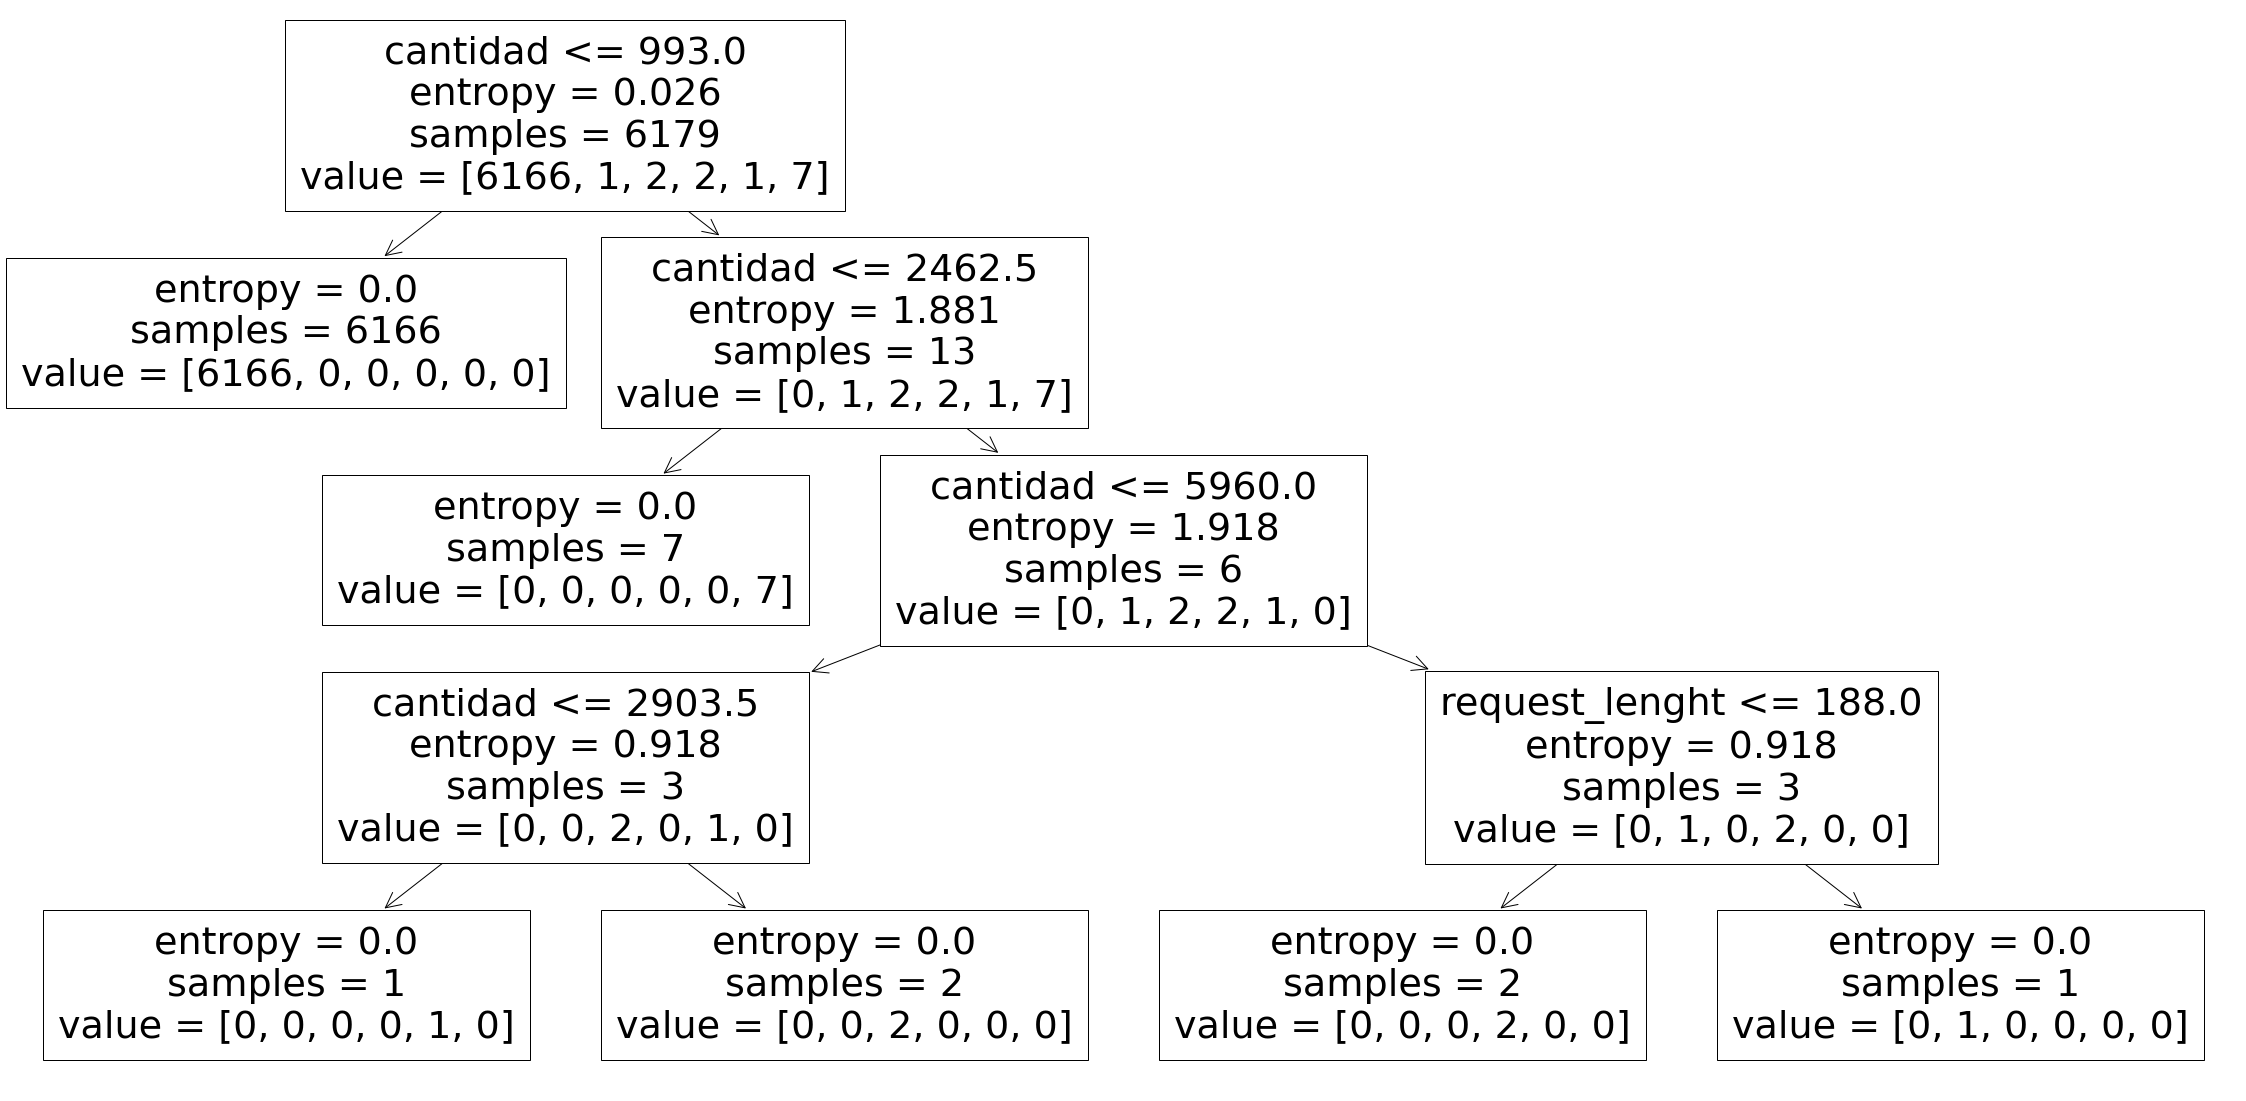

In [23]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot", "request_lenght"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)

from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["cantidad", "tamaño", "spambot", 'request_lenght']))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["cantidad", "tamaño", "spambot", "request_lenght"])
plt.show()



In [24]:
df_groupby_ip[(df_groupby_ip["cluster"] != 1) & (df_groupby_ip["spambot"] == 0)]

,ip,count,size,request_lenght,spambot,cluster
0,1.38.188.99,1,712495,112,0,0
1,1.47.151.27,2,1630020,32,0,0
2,1.85.11.244,1,497562,32,0,0
3,100.24.12.213,2,13623,32,0,0
4,101.108.5.245,1,7725352,32,0,0
...,...,...,...,...,...,...
8823,98.126.219.75,2,1184056,98,0,0
8824,98.167.168.137,2,224700,88,0,0
8825,98.176.225.232,2,14582,32,0,0
8826,99.150.195.19,6,53034,33,0,0
